In [10]:
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import cellpose
from cellpose import utils, io, models, plot
from cellpose.utils import outlines_list, masks_to_outlines
import os, sys
import glob
import cv2
from shapely.geometry import Polygon
import torch
import importlib
importlib.reload(models)
import csv
from pathlib import Path

currentdir = os.path.dirname(os.path.realpath('cell_polygons.ipynb'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

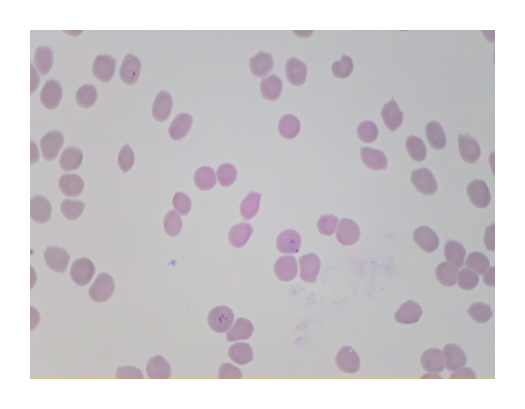

In [2]:
#from NIH Labels (adjust txt to jpeg / png and store in org_files)

def get_jpeg(path):
    list_jpeg = []
    # Delimiter
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpeg"):
                jpeg_path = os.path.join(root, file)
                list_jpeg.append(jpeg_path)
    return list_jpeg

org_files = get_jpeg('../data/scan_clean/vgg_test')
org_files

# view 1 image
img = io.imread(org_files[0])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

In [3]:
imgs = [cv2.imread(img_path) for img_path in org_files]

In [4]:
img_height = 1024
img_width = 1024
img_channels = 3
imgs_red = np.zeros((len(imgs), img_height, img_width, img_channels), dtype=np.uint8)
sizes_imgs_red = []
for idx, img in enumerate(imgs):
    img_red = cv2.resize(img, (img_height, img_width))
    #Append image to numpy array
    imgs_red[idx] = img_red
    #Append image shape to numpy array
    sizes_imgs_red.append([img_red.shape[0], img_red.shape[1]])

In [5]:
imgs_red[0].shape

(1024, 1024, 3)

In [6]:
diameter = 170

In [7]:
#outlines_ls = outlines_list(masks)

def outlines_to_x_y(outlines):
    arr_x = []
    arr_y = []
    for cell in outlines:
        arr_x.append(cell.flatten()[::2])
        arr_y.append(cell.flatten()[1::2])
    return arr_x, arr_y


In [8]:
#for loop which executes cell pose and stores polygons in region list

region = []
img_len = len(imgs_red)
model = models.Cellpose(gpu=True, model_type='cyto')
masks_all = []
count = 0

for i in range(img_len):
    chan = [0, 0] # for black and white imgs
    masks, flows, styles, diams = model.eval(imgs[i], 
                                 diameter= diameter, 
                                 channels=chan,
                                 invert = True,
                                 flow_threshold = 1)
    masks_all.append(masks)
    outlines_ls = outlines_list(masks_all[i])
    out_len = len(outlines_ls)
    x, y = outlines_to_x_y(outlines_ls)
    for j in range(out_len):
        region_temp = []
        region_temp.append(org_files[i].split("/")[-1]) #filename 
        region_temp.append(Path(org_files[i]).stat().st_size) #file_size
        region_temp.append('{}') #file_attributes
        region_temp.append(out_len) #region_count
        region_temp.append(count) #region_id
        region_temp.append(str("{\"name\":\"polygon\",\"all_points_x\":["+','.join([str(i) for i in x[j]])+"],\"all_points_y\":["+','.join([str(i) for i in y[j]])+"]}"))  #region_shape_attributes
        region_temp.append('{\"RBC\":\"uninfected\"}') #region_attributes
        region.append(region_temp)
        count += 1 #count for region_id
        

TORCH CUDA version not installed/working.
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 68.28s; flow+mask computation 2.86
estimated masks for 1 image(s) in 71.80 sec
>>>> TOTAL TIME 71.80 sec
processing 1 image(s)
time spent: running network 44.87s; flow+mask computation 2.49
estimated masks for 1 image(s) in 48.15 sec
>>>> TOTAL TIME 48.15 sec
processing 1 image(s)
time spent: running network 52.28s; flow+mask computation 2.50
estimated masks for 1 image(s) in 55.34 sec
>>>> TOTAL TIME 55.34 sec
processing 1 image(s)
time spent: running network 50.53s; flow+mask computation 2.62
estimated masks for 1 image(s) in 54.29 sec
>>>> TOTAL TIME 54.29 sec


In [9]:
df_region=pd.DataFrame(region,columns=['filename','file_size','file_attributes','region_count','region_id','region_shape_attributes','region_attributes'])

df_region.to_csv('../data/vgg_annotations/poly_annotation.csv', index = False)
